In [1]:
from datasets import load_dataset

# dataset_name = "dim/nfs_pix2pix_1920_1080_v5"
dataset_name = "dim/nfs_pix2pix_1920_1080_v5_upscale_2x_raw"
dataset = load_dataset(
    dataset_name,
    cache_dir=f"/code/dataset/{dataset_name.split('/')[-1]}",
)
dataset = dataset["train"]

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.9.0+cu130 with CUDA 1300 (you have 2.9.0+cu128)
    Python  3.10.19 (you have 3.11.14)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


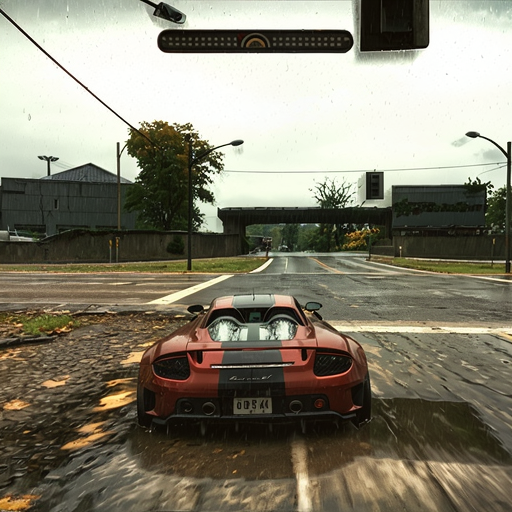

In [2]:
import torchvision.transforms.functional as F

import torch
from torchvision import transforms

from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    StableDiffusionPipeline,
    UNet2DConditionModel,
    StableDiffusionImg2ImgPipeline,
    AutoencoderTiny,
    UNet2DModel,
    AutoencoderKLWan,
)
from transformers import CLIPTextModel, CLIPTokenizer
import torch

# weight_dtype = torch.float32
weight_dtype = torch.bfloat16
# vae = AutoencoderTiny.from_pretrained(
#     # checkpt_path,
#     # "madebyollin/taesd",
#     # "madebyollin/taef1",
#     # "madebyollin/taesd3",
#     # "madebyollin/taesd-x4-upscaler",
#     torch_device="cuda",
#     # subfolder="vae",
#     torch_dtype=weight_dtype,
# )
vae = AutoencoderKL.from_pretrained(
    # vae = AutoencoderKLWan.from_pretrained(
    # "Tongyi-MAI/Z-Image-Turbo",
    # "stabilityai/stable-diffusion-3.5-large",
    # "Wan-AI/Wan2.2-I2V-A14B-Diffusers",
    # "AiArtLab/sdxl_vae",
    # "stable-diffusion-v1-5/stable-diffusion-v1-5",
    "black-forest-labs/FLUX.1-dev",
    # "black-forest-labs/FLUX.2-dev",
    subfolder="vae",
    low_cpu_mem_usage=False,
    torch_dtype=weight_dtype,
)
# vae.decoder.ignore_skip = False
vae.cuda()
device = "cuda"

size = 512
valid_transforms = transforms.Compose(
    [
        transforms.Resize(
            size,
            interpolation=transforms.InterpolationMode.LANCZOS,
        ),
        transforms.CenterCrop(size),
    ]
)
# pos = 727
pos = 527
# pos = 327
# pos = 227
input_image = dataset[pos]["input_image"].convert("RGB")
prompt = dataset[0]["edit_prompt"]
target_image = valid_transforms(dataset[pos]["edited_image"].convert("RGB"))

i_t = valid_transforms(target_image)
c_t = F.to_tensor(i_t)
c_t = c_t.unsqueeze(0)
c_t = c_t.cuda().to(weight_dtype)
norm = transforms.Normalize([0.5], [0.5])(c_t)
with torch.no_grad():
    encoded_control = (
        vae.encode(norm, return_dict=False)[0].sample()
        # vae.encode(norm, return_dict=False)[0]
        * vae.config.scaling_factor
    )
    output_image = (
        vae.decode(
            encoded_control / vae.config.scaling_factor,
            return_dict=False,
        )[0]
    ).clamp(-1, 1)
transforms.ToPILImage()((output_image[0] * 0.5 + 0.5).float().cpu())

In [4]:
encoded_control.shape

torch.Size([1, 16, 64, 64])

Jupyter compare_view v0.2.4



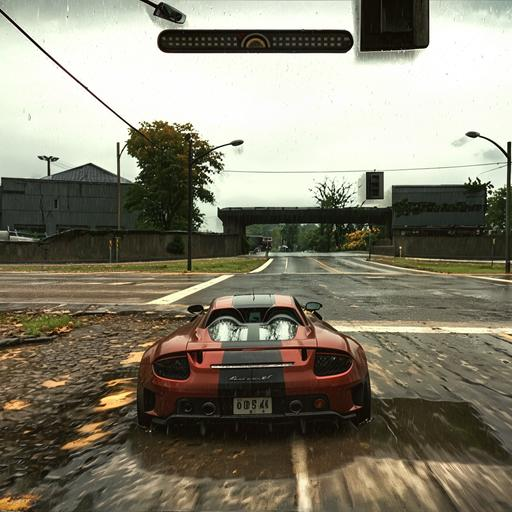
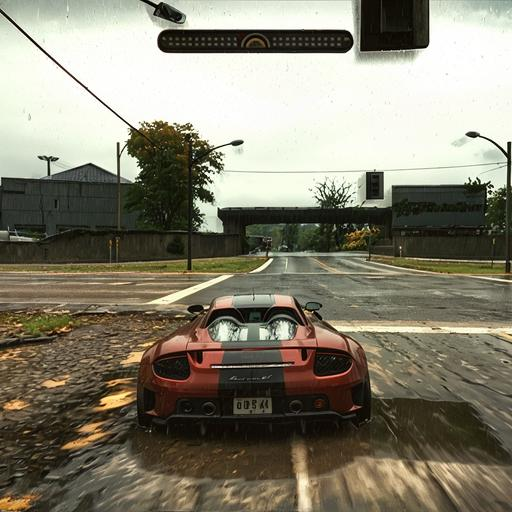

In [3]:
img = valid_transforms(dataset[pos]["edited_image"]).convert("RGB")
grayscale_img = transforms.ToPILImage()(
    (output_image[0] * 0.5 + 0.5).float().cpu()
).convert("RGB")

from jupyter_compare_view import compare

compare(img, grayscale_img, cmap="gray", start_mode="horizontal", start_slider_pos=0.73)

The config attributes {'auto_map': {'AutoModel': 'flux2_tiny_autoencoder.Flux2TinyAutoEncoder'}} were passed to Flux2TinyAutoEncoder, but are not expected and will be ignored. Please verify your config.json configuration file.



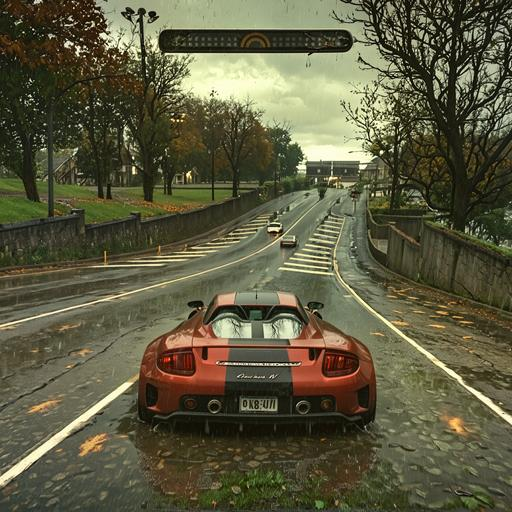
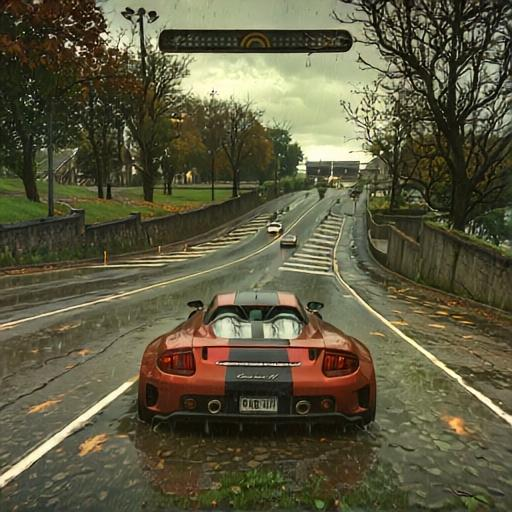

In [7]:
import torch
import torchvision.transforms.functional as F

from PIL import Image
from auto_remaster.sandbox.flux2_tiny_autoencoder import Flux2TinyAutoEncoder

device = torch.device("cuda")
tiny_vae = Flux2TinyAutoEncoder.from_pretrained(
    "fal/FLUX.2-Tiny-AutoEncoder",
).to(device=device, dtype=torch.bfloat16)
pos = 727
# pos = 527
# pos = 327
pil_image = valid_transforms(dataset[pos]["edited_image"]).convert("RGB")
image_tensor = F.to_tensor(pil_image)
image_tensor = image_tensor.unsqueeze(0) * 2.0 - 1.0
image_tensor = image_tensor.to(device, dtype=tiny_vae.dtype)

with torch.inference_mode():
    latents = tiny_vae.encode(image_tensor, return_dict=False)
    recon = tiny_vae.decode(latents, return_dict=False)
    recon = recon.squeeze(0).clamp(-1, 1) / 2.0 + 0.5
    recon = recon.float().detach().cpu()

recon_image = F.to_pil_image(recon)
compare(
    pil_image, recon_image, cmap="gray", start_mode="horizontal", start_slider_pos=0.73
)

In [10]:
import time

amount = 400
start = time.time()
for _ in range(amount):
    latents = tiny_vae.encode(image_tensor, return_dict=False)
    recon = tiny_vae.decode(latents, return_dict=False)
total = time.time() - start
print(f"total {total}s, {total/amount}s per img {1/(total/amount)}fps")

total 1.7630019187927246s, 0.004407504796981812s per img 226.8857428549559fps


In [ ]:
64 * 64 * 16

65536

In [ ]:
128 * 32 * 32

131072